# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
dilatz = 0

In [3]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filenames1 = ['ccbar0']
filenames1 = ['ccbar0','phi0']
filenames1 = ['ccbar_20M','phi0']
filenames2 = ['dalitz_25M_v0']
filenames2 = ['photon_100M_v0','photon_100M_v1']
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500

In [4]:
if True:
    data = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        data = pd.concat([data,idata], sort=False)
    data.loc[data['IsTrue0'] > -99, 'IsTrue0'] = 1

    for ifile in range(0,len(filenames2)):
        idata = pd.read_csv(filepath+f'{filenames2[ifile]}.csv')
        idata.loc[idata['IsTrue0'] > -99, 'IsTrue0'] = 0
        data = pd.concat([data,idata], sort=False)

    data = data.sample(frac = 1)
    float_columns=('Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore',\
                   'sdphi0','sdthe0','SecondHitPhiR0','SecondHitPhiL0','SecondHitTheR0','SecondHitTheL0',\
                   'sdphi1','sdthe1','SecondHitPhiR1','SecondHitPhiL1','SecondHitTheR1','SecondHitTheL1',\
                   'sdphi2','sdthe2','SecondHitPhiR2','SecondHitPhiL2','SecondHitTheR2','SecondHitTheL2',\
                   'sdphi3','sdthe3','SecondHitPhiR3','SecondHitPhiL3','SecondHitTheR3','SecondHitTheL3')
    int_columns=('NBDThit','Centrality', 'Charge', 'Arm','IsTrue0','IsTrue1','IsTrue2','IsTrue3')
    
    for float_column in float_columns:
        data[float_column] = data[float_column].astype('float16')
    for int_column in int_columns:
        data[int_column] = data[int_column].astype('int32')
        
    data = data[(data['Pt'] < 25) & (data['Ecore'] > 0.1) & (data['Ecore'] < 25) ]
    if dilatz:
        data = data[(data['Pt'] < 5)  ]
    

    data.head()

In [5]:
data.head()

,NBDThit,Pt,Phi0,The0,PhiDC,ZDC,Alpha,Ecore,Centrality,Charge,...,SecondHitPhiL2,SecondHitTheR2,SecondHitTheL2,sdphi3,sdthe3,IsTrue3,SecondHitPhiR3,SecondHitPhiL3,SecondHitTheR3,SecondHitTheL3
10015025,1,0.300293,3.974609,1.511719,3.263672,9.906250,0.344971,0.180542,39,-1,...,31.375000,9.671875,25.500000,-10.000000,-10.000000,0,-99.000000,-99.000000,-99.000000,-99.000000
5067628,3,0.346680,-1.085938,1.335938,-0.475098,51.468750,-0.307861,0.324219,66,1,...,-99.000000,-99.000000,-99.000000,-10.000000,-10.000000,0,-99.000000,-99.000000,-99.000000,-99.000000
7490487,3,0.731445,3.628906,1.596680,3.351562,-5.726562,0.139160,0.651367,90,-1,...,-99.000000,-99.000000,-99.000000,-10.000000,-10.000000,0,-99.000000,-99.000000,-99.000000,-99.000000
4952403,3,0.512207,2.982422,1.811523,2.562500,-52.375000,0.212524,0.477539,36,-1,...,17.296875,-99.000000,-9.640625,0.770508,-1.525391,0,1.944336,17.765625,-8.703125,-3.939453
1784714,1,0.335693,-0.582031,1.696289,0.042755,-26.781250,-0.308594,0.291016,87,1,...,-99.000000,-99.000000,-99.000000,-10.000000,-10.000000,0,-99.000000,50.000000,-99.000000,-35.125000


In [6]:
print(data.size, data.shape)

752173617 (19286503, 39)


In [7]:
# удалим лишние колонки
data = data.drop(columns = ['IsTrue1','IsTrue2','IsTrue3','sdphi0','sdphi1','sdphi2','sdphi3','sdthe0','sdthe1','sdthe2','sdthe3'])

In [8]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(4, 3, figsize=(15, 6))
    for i, feature in enumerate(['IsTrue0', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore' ]):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


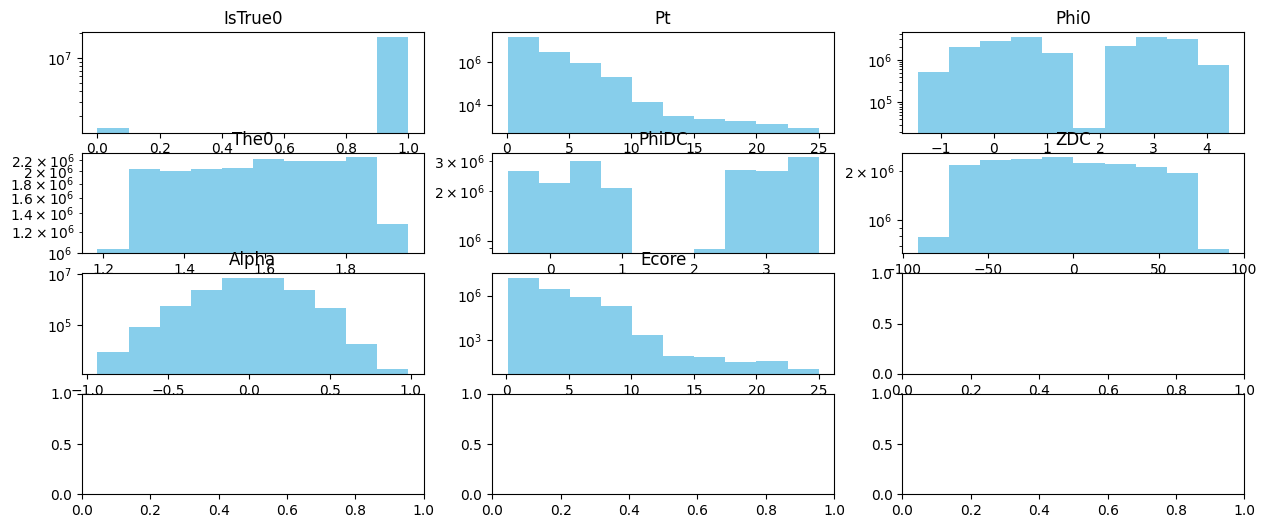

In [9]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [10]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['IsTrue0']
    data = data.drop(columns = ['IsTrue0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [11]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

6428834 12857669


In [12]:
X_test

,NBDThit,Pt,Phi0,The0,PhiDC,ZDC,Alpha,Ecore,Centrality,Charge,...,SecondHitTheR1,SecondHitTheL1,SecondHitPhiR2,SecondHitPhiL2,SecondHitTheR2,SecondHitTheL2,SecondHitPhiR3,SecondHitPhiL3,SecondHitTheR3,SecondHitTheL3
663897,4,3.417969,3.050781,1.551758,3.111328,4.296875,-0.029556,3.347656,17,1,...,-19.546875,-65.875000,0.000000,6.957031,-6.000000,-1.817383,-99.000000,6.136719,-99.000000,-3.568359
4684658,4,2.822266,-0.395264,1.846680,-0.321045,-62.468750,-0.038544,2.744141,66,1,...,12.937500,13.804688,-99.000000,-99.000000,-99.000000,-99.000000,0.000000,-99.000000,0.000000,-99.000000
693762,3,2.884766,-0.454102,1.514648,-0.524902,12.320312,0.036011,2.697266,51,-1,...,-4.226562,-99.000000,2.740234,-99.000000,9.359375,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
975768,5,0.215820,1.020508,1.241211,-0.018784,68.125000,0.501465,0.139038,78,-1,...,-97.000000,-96.562500,702.500000,697.500000,-96.937500,-96.312500,-0.000000,699.500000,-1.620117,-96.562500
5110122,1,1.751953,0.115234,1.450195,-0.000789,26.734375,0.058258,1.508789,57,-1,...,16.375000,-99.000000,-0.000000,-99.000000,10.835938,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783249,2,1.498047,3.242188,1.270508,3.095703,67.875000,0.077271,1.572266,76,-1,...,0.000000,-0.258057,-99.000000,14.976562,-99.000000,-0.751465,-0.000000,-99.000000,0.000000,-99.000000
913570,6,0.973145,0.173584,1.637695,0.382080,-14.812500,-0.104736,0.899902,56,1,...,0.000000,-1.747070,-99.000000,7.925781,-99.000000,-0.879883,0.000000,45.843750,0.000000,10.898438
4898876,3,0.287598,0.873535,1.650391,0.133911,-15.062500,0.360596,0.315674,46,-1,...,-12.820312,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,23.484375,4.964844,6.058594,5.121094
6738886,4,0.281738,1.125000,1.861328,0.354980,-63.031250,0.385498,0.363525,15,-1,...,15.039062,15.085938,-99.000000,14.046875,-99.000000,-3.818359,-0.000000,-99.000000,0.000000,-99.000000


In [13]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [14]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.09      1.00      0.16    481969
           1       1.00      0.15      0.26   5946865

    accuracy                           0.22   6428834
   macro avg       0.54      0.58      0.21   6428834
weighted avg       0.93      0.22      0.26   6428834

confusion matrix
[[ 481958      11]
 [5046268  900597]]


In [15]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [0.01, 0.2],
    "max_depth":[12],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[20]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=8)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

точность:  0.5850795027527542
{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 20}
0.6037886476268561
time of execution (sec) 1328.8466765880585


# Cross Validation

In [16]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.15      1.00      0.27    481969
           1       1.00      0.55      0.71   5946865

    accuracy                           0.59   6428834
   macro avg       0.58      0.78      0.49   6428834
weighted avg       0.94      0.59      0.68   6428834



In [17]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.016752426883647767
roc auc: 0.9836340434078261
f1 score: 0.9587699958456432


Text(0.5, 1.0, 'ROC AUC Curve')

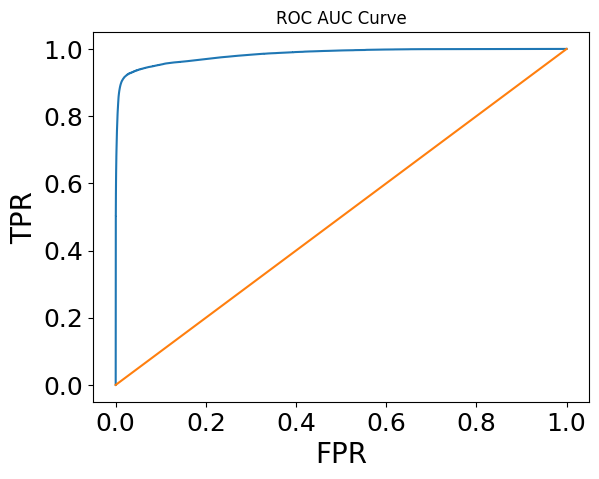

In [18]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title('ROC AUC Curve')

In [19]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.2663088198843826


In [70]:
i = 670000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.823 0.0059
0.13140820118189694 0.004832260996039164 0.8228905482132183


In [59]:
print(sum(predicted),len(predicted))

3279796 6428834


In [60]:
kek_data = data
kek_data = kek_data.drop(columns = ['IsTrue0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.9653829896156356


In [61]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_Conv.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 50, 0, 5, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 50, 0, 5, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 50, 0, 5, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 50, 0, 5, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 50, 0, 5, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 50, 0, 5, 10, 0, 100)

In [62]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

sigma, sigma_veto = 3, -2

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>4000000: break
    sdphi0, sdphi1, sdphi2, sdphi3 = 0, 0, 0, 0
    sdthe0, sdthe1, sdthe2, sdthe3 = 0, 0, 0, 0
    centrality, pt, IsTrue0 = row['Centrality'], row['Pt'], row['IsTrue0']

    if pt<0.4 or centrality<0: continue
    
    if IsTrue0: e_pt_hist_NC.Fill(pt,centrality)
    else:    h_pt_hist_NC.Fill(pt,centrality)
    if sdphi0>sigma_veto and ( abs(sdphi0) < sigma and abs(sdthe0) < sigma and abs(sdphi1) < sigma and abs(sdthe1) < sigma ) and ( ( abs(sdphi2) < sigma and abs(sdthe2) < sigma ) or ( abs(sdphi3) < sigma and abs(sdthe3) < sigma ) ):
        if IsTrue0: 
            mycute+=1
            e_pt_hist_SC.Fill(pt,centrality)
        else: 
            mycuth+=1+hadron_weight
            h_pt_hist_SC.Fill(pt,centrality)
    if proba_loc[counter][1]>thresholds[i]: 
        if IsTrue0: 
            AIcute+=1
            e_pt_hist_AI.Fill(pt,centrality)
        else: 
            AIcuth+=1+hadron_weight
            h_pt_hist_AI.Fill(pt,centrality)
    if IsTrue0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [63]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

3088206 534043532.0 1.0 1.0 0.859 0.005 0.006 0.006


In [64]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

178.227 0.859 0.005 5347


In [65]:
%run input/Format.ipynb

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


1829.0 18173.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


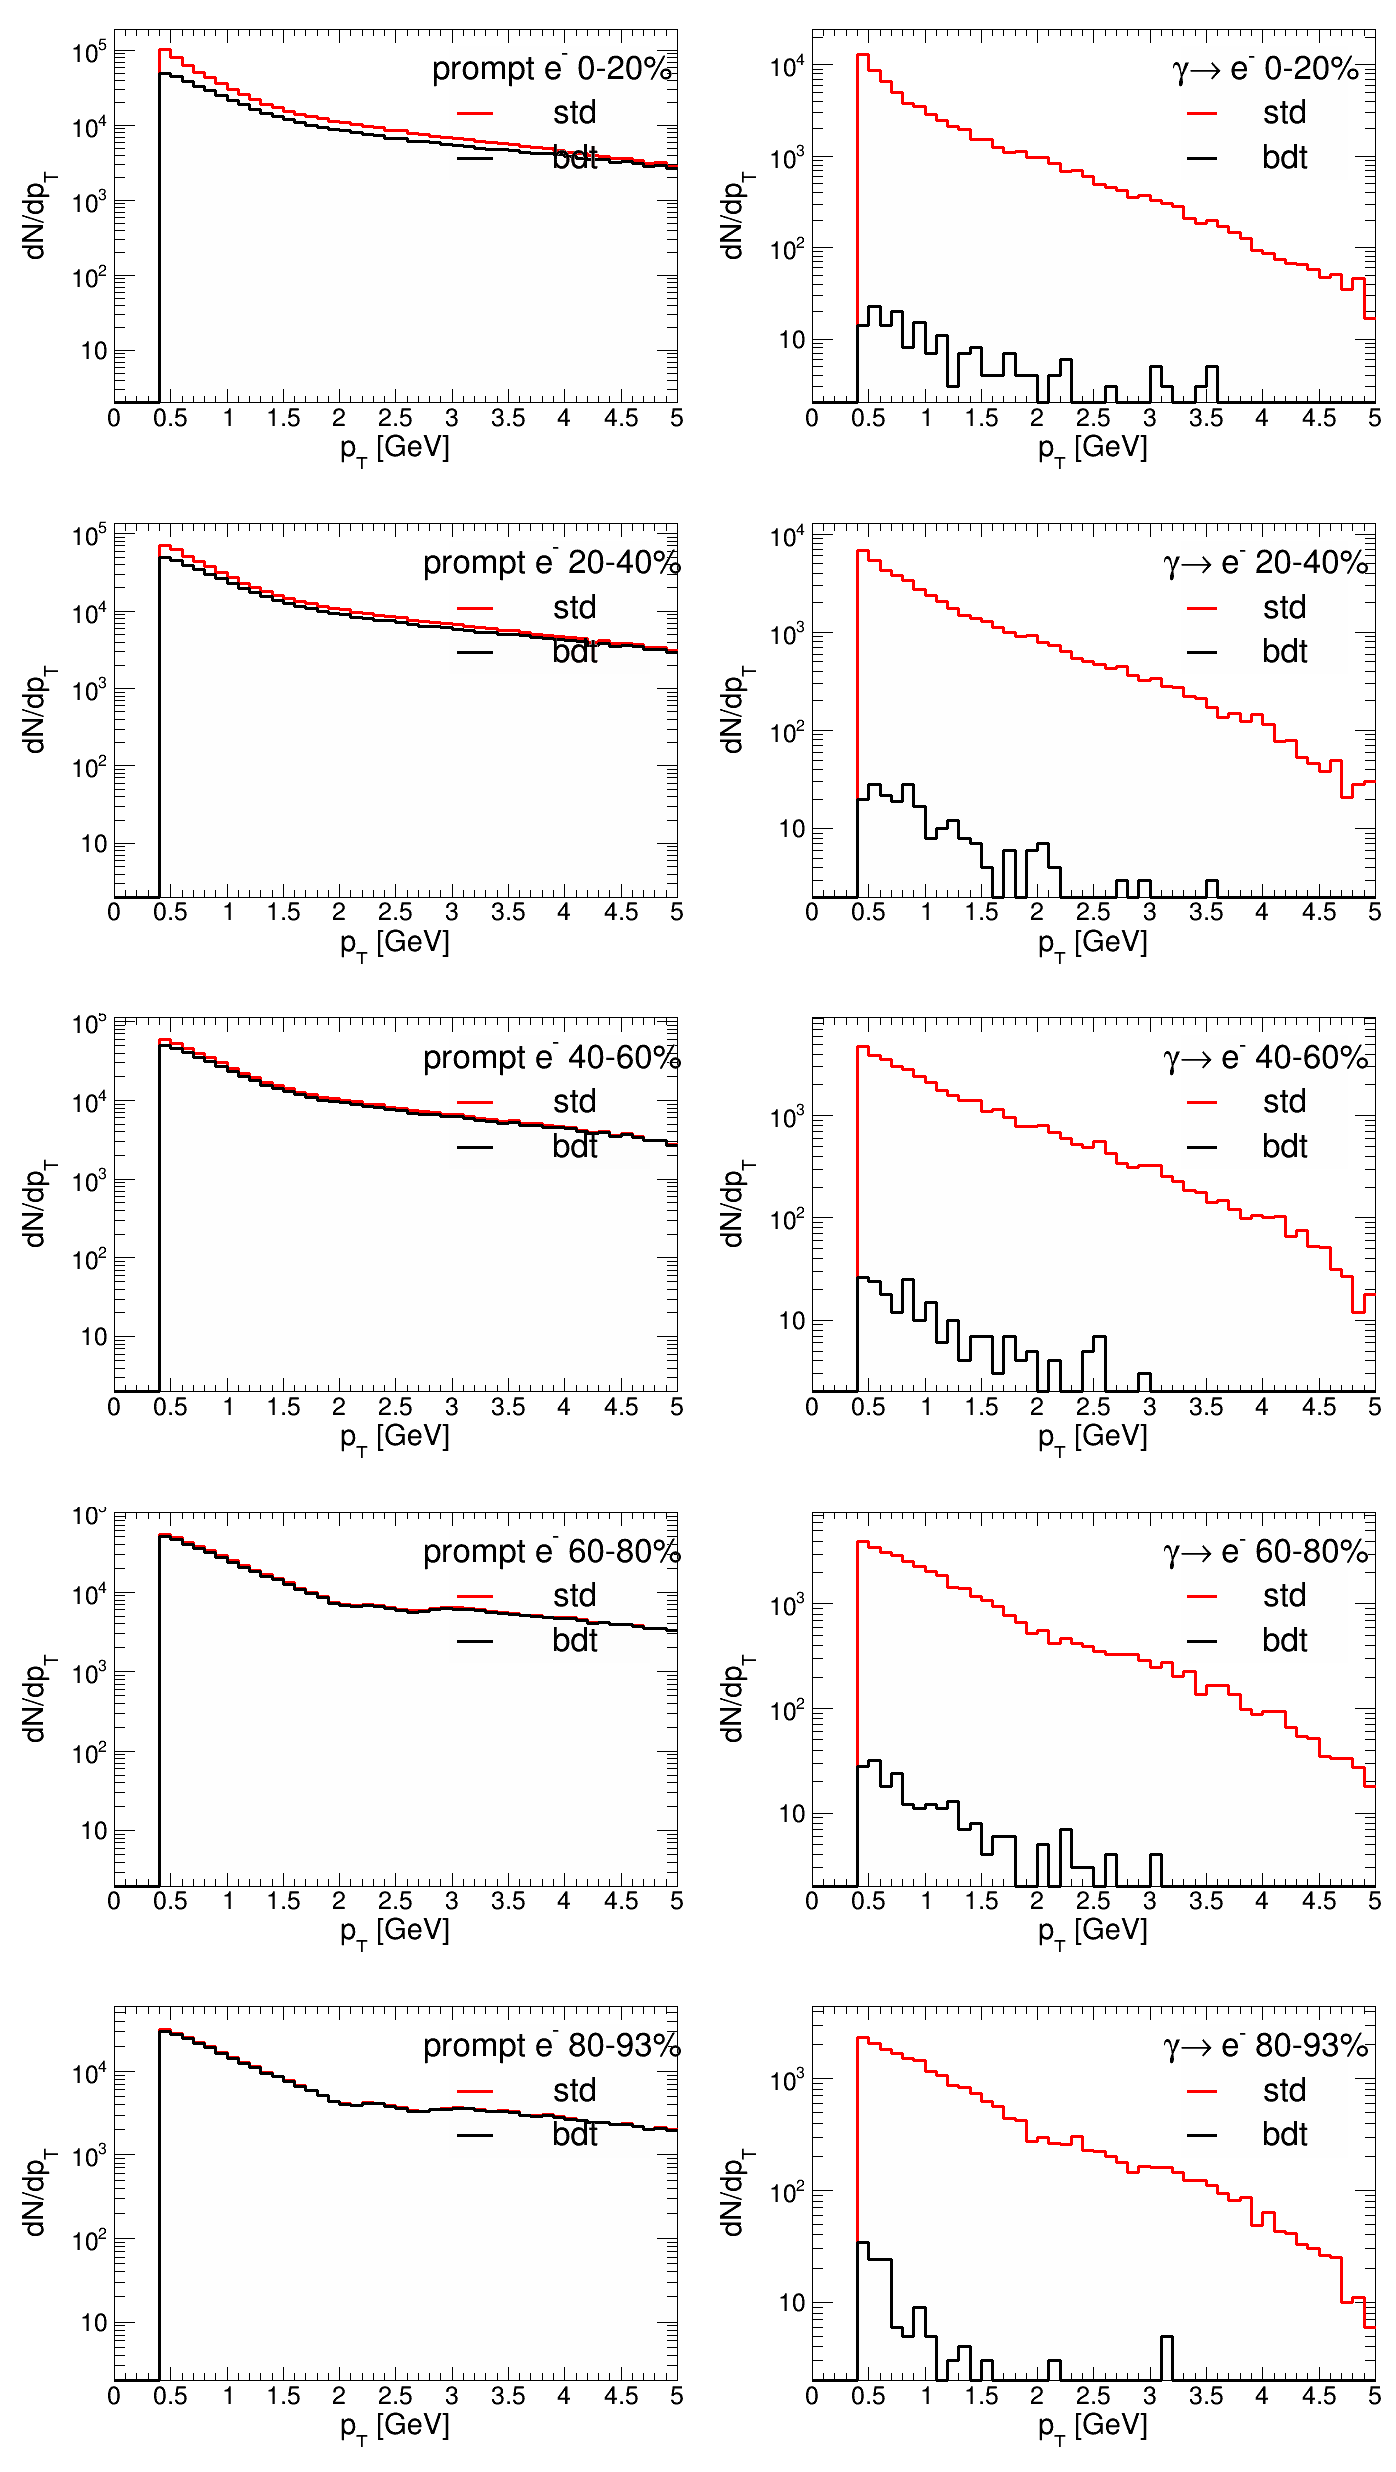

In [66]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(3)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    proj.SetMinimum(2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw()
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2).Draw("same")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2),"std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2)
    projh.Draw()
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2).Draw("same")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.7,0.65,0.95,0.95,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2),"std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

In [29]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [30]:
import pickle
with open('output/bdt_conv.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[1 1 0 1 1 1 0 1 0 0]


In [31]:
import pickle
# load
with open('output/bdt_conv.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

[1 1 0 1 1 1 0 1 0 0]


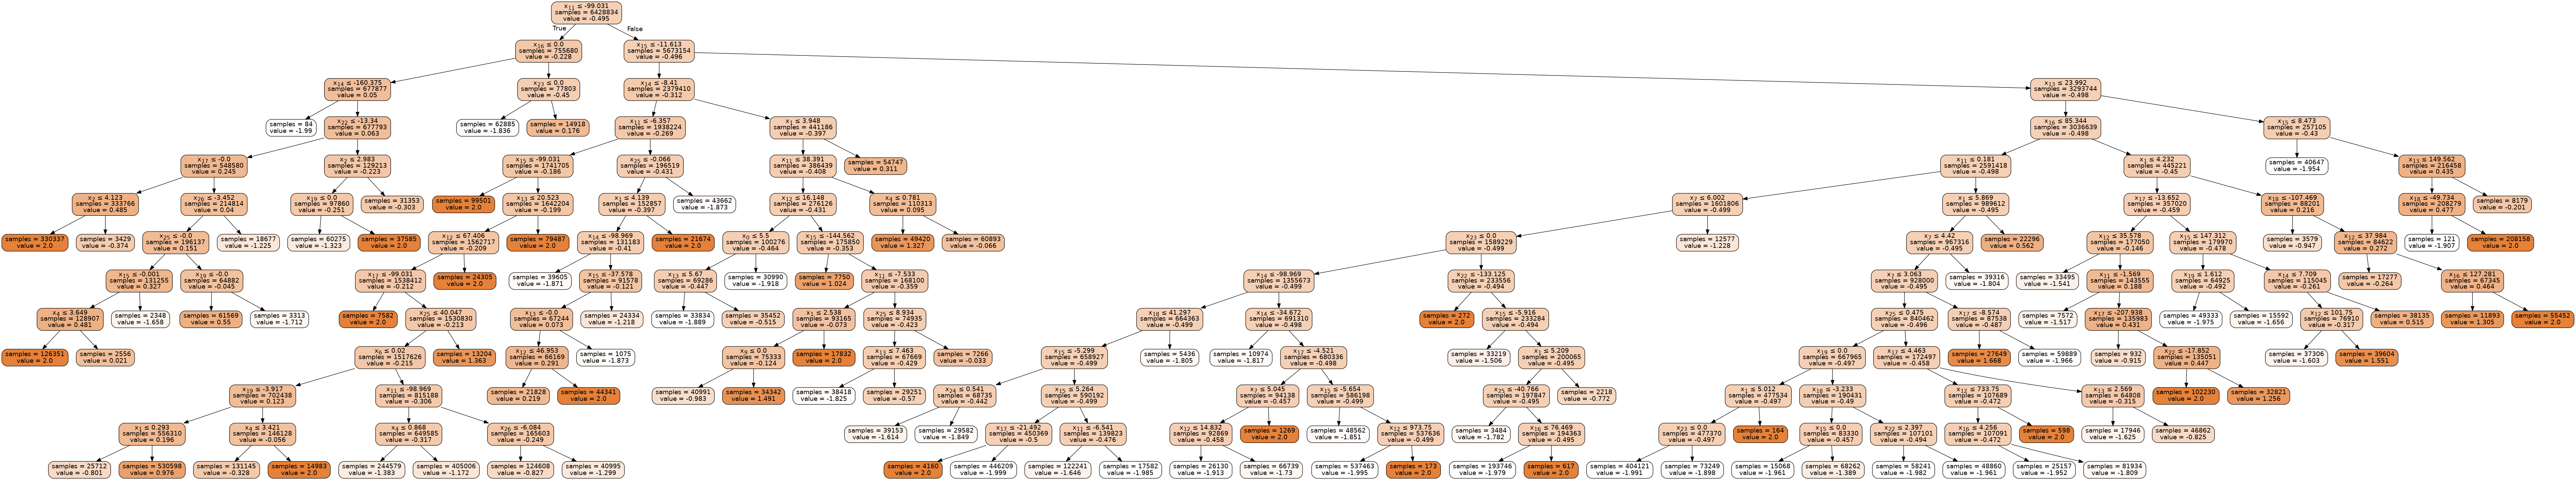

In [32]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [33]:
clf2.predict(kek_data[0:100])

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1], dtype=int32)

In [34]:
clf2.predict_proba(kek_data[0:100])

array([[0.03461701, 0.96538299],
       [0.27890483, 0.72109517],
       [0.7621688 , 0.2378312 ],
       [0.07576913, 0.92423087],
       [0.30539352, 0.69460648],
       [0.42711575, 0.57288425],
       [0.99018534, 0.00981466],
       [0.17809242, 0.82190758],
       [0.86683602, 0.13316398],
       [0.9870422 , 0.0129578 ],
       [0.81042808, 0.18957192],
       [0.33950634, 0.66049366],
       [0.01344762, 0.98655238],
       [0.02985211, 0.97014789],
       [0.60703133, 0.39296867],
       [0.00975936, 0.99024064],
       [0.18082091, 0.81917909],
       [0.89708108, 0.10291892],
       [0.99117175, 0.00882825],
       [0.3815185 , 0.6184815 ],
       [0.77023066, 0.22976934],
       [0.95067664, 0.04932336],
       [0.98430881, 0.01569119],
       [0.99118687, 0.00881313],
       [0.70114986, 0.29885014],
       [0.99092787, 0.00907213],
       [0.8791931 , 0.1208069 ],
       [0.16729762, 0.83270238],
       [0.01587039, 0.98412961],
       [0.41728641, 0.58271359],
       [0.

In [35]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 20}


In [36]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.9870422 , 0.0129578 ],
       [0.81042808, 0.18957192],
       [0.33950634, 0.66049366],
       [0.01344762, 0.98655238],
       [0.02985211, 0.97014789],
       [0.60703133, 0.39296867],
       [0.00975936, 0.99024064],
       [0.18082091, 0.81917909],
       [0.89708108, 0.10291892],
       [0.99117175, 0.00882825],
       [0.3815185 , 0.6184815 ]])

In [37]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())*0
#y = gb_clf.decision_function(kek_data[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(kek_data[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[-2.63508533 -1.24989143 -0.59055364  2.3602264   2.26054847 -1.02400515
  2.42395921  0.44760334 -2.31891597 -2.68908847]
[-5.27727538 -1.93351913 -4.53120668  0.91664384 -4.25602938 -5.27327688
 -0.0971259   0.62105934 -5.179397   -5.81918368 -2.83061409]
[0.06691424 0.22271893 0.35650783 0.91374365 0.90555655 0.26424798
 0.91863616 0.61006925 0.08956842 0.0636203 ]


In [38]:
best_gbc = clf2.best_estimator_

In [39]:
n_estim = best_gbc.n_estimators

In [40]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[-4.33301502 -1.45279414  0.66549489  4.29541425  3.48119308 -0.43485053
  4.61972114  1.51079561 -2.1652048  -4.7209306 ]
[0.0129578  0.18957192 0.66049366 0.98655238 0.97014789 0.39296867
 0.99024064 0.81917909 0.10291892 0.00882825]
0.2


In [41]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(kek_data[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(kek_data[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [42]:
print(log_odds_predictions)

[[-1.9520135634830214, -1.382978978925831, -1.9909040991100955, 2.0, 2.0, -1.9909040991100955, 2.0, 2.0, -1.9787156230634984, -1.9987546096047186], [-1.6596546367606069, -1.0013228988340543, -0.4032269971674215, 1.6809735573597782, -1.6124091351748964, 1.5240812701156299, 1.6704046219027897, -0.9691768455561807, -1.6596546367606069, -1.6702932421006709], [-1.4606311795892302, -0.7842746680832201, -1.221767588680744, 1.4860065839507024, 1.0225747684635507, -1.221767588680744, 1.6573884050004204, 0.06318301558168458, -1.3930520129494657, -1.478632915662903], [-1.3394064043512435, -0.7180003335984303, -0.11670358763293955, 1.4581806020838122, 1.5039000411247563, -0.11670358763293955, 1.385618222833044, -1.0164358546947656, -0.6295158878783441, -1.3563499916140385], [-1.2648216803523948, -0.5819096773657828, -0.9503651468897163, 1.3044029976876272, 1.7980649991743811, -0.9503651468897163, 0.35138762740554913, 1.724388555424216, -1.1847526111679083, -1.271629493737067], [-1.166811875062615,

In [43]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(kek_data[9:19]))

0.2 -2.6350853273594463
[-4.33301502 -1.45279414  0.66549489  4.29541425  3.48119308 -0.43485053
  4.61972114  1.51079561 -2.1652048  -4.7209306 ]


In [44]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

20
1
[[-1.9520135634830214, -1.6596546367606069, -1.4606311795892302, -1.3394064043512435, -1.2648216803523948, -1.166811875062615, -1.11764304420561, -1.1220220584230205, -1.0964037443959747, -0.996018450173513, -0.9979710986779872, -1.0359164030758048, -0.40282418655264, -1.0232425600717476, -0.9498956490035932, -0.48326606689928325, -0.9805772810967368, -1.0019712344315401, -0.9451749605660451, -0.6688090472647452], [-1.382978978925831, -1.0013228988340543, -0.7842746680832201, -0.7180003335984303, -0.5819096773657828, -0.500788084467423, -0.3961609797278437, -0.2249416891456312, -0.4577828170830919, -0.20129700242706092, -0.30104694825136485, -0.14369803581472904, -0.06534483218514721, -0.011426155487649855, -0.025143258128559283, -0.19213475226347618, 0.021659564892882118, -0.20893081496744087, -0.012776841906616907, -0.07567149065716908], [-1.9909040991100955, -0.4032269971674215, -1.221767588680744, -0.11670358763293955, -0.9503651468897163, -0.9609535543436529, 1.84845707600368

In [45]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [46]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {threshold})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {threshold})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [67]:
#print(f"double mytree{list(kek_data.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if (x[11] > -99.03125) and (x[15] > -11.61328125) and (x[13] <= 23.9921875) and (x[16] <= 85.34375) and (x[11] <= 0.181396484375) and (x[7] <= 6.001953125) and (x[23] <= 5.960464477539063e-08) and (x[14] > -98.96875) and (x[14] > -34.671875) and (x[17] > -4.521484375) and (x[15] > -5.654296875) and (x[12] <= 973.75) :  return -1.995011464285646  # | based on 537,463 samples
        if (x[11] > -99.03125) and (x[15] <= -11.61328125) and (x[14] <= -8.41015625) and (x[11] <= -6.357421875) and (x[15] > -99.03125) and (x[13] <= 20.5234375) and (x[12] <= 67.40625) and (x[17] > -99.03125) and (x[25] <= 40.046875) and (x[6] <= 0.02043914794921875) and (x[19] <= -3.9169921875) and (x[1] > 0.2928466796875) :  return 0.9758883070770077  # | based on 530,598 samples
        if (x[11] > -99.03125) and (x[15] > -11.61328125) and (x[13] <= 23.9921875) and (x[16] <= 85.34375) and (x[11] <= 0.181396484375) and (x[7] <= 6.001953125) and (x[23] <= 5.960464477539063e-0

In [48]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {threshold})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {threshold})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [49]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[11] > -99.03125) and (x[15] > -11.61328125) and (x[13] <= 23.9921875) and (x[16] <= 85.34375) and (x[11] <= 0.181396484375) and (x[7] <= 6.001953125) and (x[23] <= 5.960464477539063e-08) and (x[14] > -98.96875) and (x[14] > -34.671875) and (x[17] > -4.521484375) and (x[15] > -5.654296875) and (x[12] <= 973.75) :  return -1.995011464285646  # | based on 537,463 samples
        if (x[11] > -99.03125) and (x[15] <= -11.61328125) and (x[14] <= -8.41015625) and (x[11] <= -6.357421875) and (x[15] > -99.03125) and (x[13] <= 20.5234375) and (x[12] <= 67.40625) and (x[17] > -99.03125) and (x[25] <= 40.046875) and (x[6] <= 0.02043914794921875) and (x[19] <= -3.9169921875) and (x[1] > 0.2928466796875) :  return 0.9758883070770077  # | based on 530,598 samples
        if (x[11] > -99.03125) and (x[15] > -11.61328125) and (x[13] <= 23.9921875) and (x[16] <= 85.34375) and (x[11] <= 0.181396484375) and (x[7] <= 6.001953125) and (x[23] <= 5.

In [50]:
def mytree(x,y):
    return 0

In [51]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [52]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [53]:
kek_data[9:19].values.tolist()[0][31]

IndexError: list index out of range

In [ ]:
iestim = 19
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(kek_data[9:10].values.tolist())
print(y)
print(kek_data[9+i:10+i].values.tolist()[0][15])
myf = [mytree(iestim, kek_data[9+i:10+i].values.tolist()[0]) for i in range(1)]
print(myf)

[-0.802971]
-6.8984375
[-0.8029710007054855]


In [ ]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(kek_data[9:19].values.tolist())
print(y)

myf = [mygradboost(kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.91942784 0.08057216]
 [0.38709394 0.61290606]
 [0.1467262  0.8532738 ]
 [0.93157704 0.06842296]
 [0.76337017 0.23662983]
 [0.03350122 0.96649878]
 [0.16814564 0.83185436]
 [0.61864028 0.38135972]
 [0.01741641 0.98258359]
 [0.71489587 0.28510413]]
[0.08057216077636163, 0.6129060649420737, 0.8532738045887558, 0.06842296487388662, 0.2366298295681941, 0.9664987829264831, 0.831854355571723, 0.38135972490406794, 0.9825835896284822, 0.28510412941599644]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
column_headers = list(kek_data.columns.values)
print(column_headers)
print(len(column_headers))

SecondHitPhiR3
35
